<a href="https://colab.research.google.com/github/cbachen1997/CAUstudy/blob/master/trainModel_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##基础部分

In [ ]:
#挂载谷歌云盘
from google.colab import drive
drive.mount('/content/gdrive')
####google云盘授权#####
##每个notebook执行一次###
__author__='CBA'
from google.colab import drive

#增加PyDrive操作库|
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#授权登录
auth.authenticate_user()
gauth=GoogleAuth()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# !pip uninstall keras -y
# !pip uninstall keras-nightly -y
# !pip uninstall keras-Preprocessing -y
# !pip uninstall keras-vis -y
# !pip uninstall tensorflow -y

# !pip install tensorflow==2.3.0
# !pip install keras==2.4
# !pip install -U efficientnet

In [ ]:
import tensorflow as tf
from sklearn.utils import shuffle
import tifffile as tiff
from tensorflow import keras as K
import tensorflow.keras.layers as L
import numpy as np
import os
import time
import h5py
import argparse 
import random
import cv2
from tqdm import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LambdaCallback
# from keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from __future__ import print_function, division
from tensorflow.keras.layers import *
# from keras.layers import Dense,Dropout
from sklearn.utils import shuffle
# from keras.layers.core import Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LeakyReLU
# from tensorflow.keras.layers.core import Lambda
from tensorflow.keras import backend as Kb
from collections import Counter
from tensorflow.keras.activations import relu,softmax
from keras.utils import plot_model
#网络
import efficientnet.keras as efn
from keras.layers.wrappers import Bidirectional
import matplotlib.pyplot as plt


Using TensorFlow backend.


##参数

In [ ]:
inputShape = (224,224,3)
# inputShape = (380,380,3)
inputShapeLSTM = (4,1000)
TIME_STEPS = 4
SINGLE_ATTENTION_VECTOR = False

#MDN-CNN部分（Non-local)

In [ ]:
def BN_LeakyReLU(input):
  norm = BatchNormalization(axis=-1)(input)
  output = LeakyReLU(alpha=0.2)(norm)
  
  return output

def MDCN(input_layers, n_filters):
    
  # stream_left
  conv_left = Conv2D(n_filters, (3, 3), padding='same', dilation_rate = 4, kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(0.0001))(input_layers)
  conv_left = BN_LeakyReLU(conv_left)
  # stream_middle_up
  conv_middle_1 = Conv2D(n_filters, (3, 3), padding='same', dilation_rate = 3, kernel_initializer='he_normal',
                          kernel_regularizer=regularizers.l2(0.0001))(input_layers)
  conv_middle_1 = BN_LeakyReLU(conv_middle_1)
  # stream_right_up
  conv_right_1 = Conv2D(n_filters, (3, 3), padding='same', dilation_rate = 2, kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l2(0.0001))(input_layers)
  conv_right_1 = BN_LeakyReLU(conv_right_1)
  conv_right_2 = Conv2D(n_filters, (3, 3), padding='same', dilation_rate = 2, kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l2(0.0001))(conv_right_1)
  conv_right_2 = BN_LeakyReLU(conv_right_2)
  
  # stream_sum_1
  sum_1 = add([conv_middle_1, conv_right_2])
  
  # stream_middle_down
  conv_middle_2 = Conv2D(n_filters, (3, 3), padding='same', dilation_rate = 3, kernel_initializer='he_normal',
                          kernel_regularizer=regularizers.l2(0.0001))(sum_1)
  conv_middle_2 = BN_LeakyReLU(conv_middle_2)
  # stream_right_down
  conv_right_3 = Conv2D(n_filters, (3, 3), padding='same', dilation_rate = 2, kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l2(0.0001))(sum_1)
  conv_right_3 = BN_LeakyReLU(conv_right_3)
  conv_right_4 = Conv2D(n_filters, (3, 3), padding='same', dilation_rate = 2, kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l2(0.0001))(conv_right_3)
  conv_right_4 = BN_LeakyReLU(conv_right_4)
  
  # stream_sum_2
  sum_2 = add([conv_left, conv_middle_2, conv_right_4])
  
  return sum_2
def transpose(input):
  x=tf.transpose(input, perm=[0, 2, 1])
  return x

def expand_dims1(input):
  x=tf.expand_dims(input, axis=1)
  return x

def expand_dims2(input):
  x=tf.expand_dims(input, axis=-1)
  return x

def matmul(input):
  """input must be a  list"""
  return tf.matmul(input[0],input[1])

def gcnet_layer(inputs):
    
  x=inputs
  bs, h, w, c = x.get_shape().as_list()
  input_x = x
  input_x = Reshape((-1, c))(input_x)  # [N, H*W, C]
  input_x = Lambda(transpose)(input_x)  # [N,C,H*W]
  input_x = Lambda(expand_dims1)(input_x)

  context_mask = Conv2D(filters=1, kernel_size=(1, 1))(x)
  context_mask = Reshape((-1, 1))(context_mask)
  context_mask = softmax(context_mask, axis=1)  # [N, H*W, 1]
  context_mask = Lambda(transpose)(context_mask)
  context_mask = Lambda(expand_dims2)(context_mask)

  context = Lambda(matmul)([input_x,context_mask])  # [N,1,c,1]
  context = Reshape((1, 1, c))(context)

  context_transform = Conv2D(int(c/8), (1, 1))(context)
  context_transform = LayerNormalization()(context_transform)
  context_transform = relu(context_transform)
  context_transform = Conv2D(c, (1, 1))(context_transform)

  x= add([x,context_transform])

  return x


In [ ]:
def DNCNN(input_layer):
  n_filters = 64
  
  # input_layer = L.Input(shape=inputShape)
  conv_1 = Conv2D(n_filters, (7, 7), padding='valid', strides=(2, 2), kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(0.0001))(input_layer)
  conv_1 = BN_LeakyReLU(conv_1)
  # print('conv_1: {}'.format(conv_1.shape))
  conv_2 = Conv2D(2*n_filters, (3, 3), padding='valid', strides=(2, 2), kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(0.0001))(conv_1)
  conv_2 = BN_LeakyReLU(conv_2)
  # print('conv_2: {}'.format(conv_2.shape))
  
  block_1 = MDCN(conv_2, 2*n_filters)  # 128
  # print('block_1: {}'.format(block_1.shape))
  block_2 = MDCN(block_1, 2*n_filters)  # 128
  # print('block_2: {}'.format(block_2.shape))
  
  conv_3 = Conv2D(4*n_filters, (3, 3), padding='valid', strides=(2, 2), kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(0.0001))(block_2)
  conv_3 = BN_LeakyReLU(conv_3)
  # print('conv_3: {}'.format(conv_3.shape))
  
  block_3 = MDCN(conv_3, 4*n_filters)  # 256
  # print('block_3: {}'.format(block_3.shape))
  block_4 = MDCN(block_3, 4*n_filters)  # 256
  # print('block_4: {}'.format(block_4.shape))
  
  conv_4 = Conv2D(8*n_filters, (3, 3), padding='valid', strides=(2, 2), kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(0.0001))(block_4)  # 512
  conv_4 = BN_LeakyReLU(conv_4)
  # print('conv_4: {}'.format(conv_4.shape))
  
  block_5 = MDCN(conv_4, 8*n_filters)  # 256
  # print('block_5: {}'.format(block_5.shape))
  block_6 = MDCN(block_5, 8*n_filters)  # 256
  # print('block_6: {}'.format(block_6.shape))
  
  
  block_6 = gcnet_layer(block_6)
  
  gap = GlobalAveragePooling2D()(block_6)  # GAP
  fc = Dropout(0.5)(gap) 
  UV_result = Dense(512, activation='relu')(fc)  # FC
         #Dropout

  
  # model_DNCNN = Model(inputs=input_layer, outputs=UV_result)
 
  
  return UV_result

In [ ]:
def OnlyDNCNN(input_layer):
  n_filters = 64
  
  # input_layer = L.Input(shape=inputShape)
  conv_1 = Conv2D(n_filters, (7, 7), padding='valid', strides=(2, 2), kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(0.0001))(input_layer)
  conv_1 = BN_LeakyReLU(conv_1)
  # print('conv_1: {}'.format(conv_1.shape))
  conv_2 = Conv2D(2*n_filters, (3, 3), padding='valid', strides=(2, 2), kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(0.0001))(conv_1)
  conv_2 = BN_LeakyReLU(conv_2)
  # print('conv_2: {}'.format(conv_2.shape))
  
  block_1 = MDCN(conv_2, 2*n_filters)  # 128
  # print('block_1: {}'.format(block_1.shape))
  block_2 = MDCN(block_1, 2*n_filters)  # 128
  # print('block_2: {}'.format(block_2.shape))
  
  conv_3 = Conv2D(4*n_filters, (3, 3), padding='valid', strides=(2, 2), kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(0.0001))(block_2)
  conv_3 = BN_LeakyReLU(conv_3)
  # print('conv_3: {}'.format(conv_3.shape))
  
  block_3 = MDCN(conv_3, 4*n_filters)  # 256
  # print('block_3: {}'.format(block_3.shape))
  block_4 = MDCN(block_3, 4*n_filters)  # 256
  # print('block_4: {}'.format(block_4.shape))
  
  conv_4 = Conv2D(8*n_filters, (3, 3), padding='valid', strides=(2, 2), kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(0.0001))(block_4)  # 512
  conv_4 = BN_LeakyReLU(conv_4)
  # print('conv_4: {}'.format(conv_4.shape))
  
  block_5 = MDCN(conv_4, 8*n_filters)  # 256
  # print('block_5: {}'.format(block_5.shape))
  block_6 = MDCN(block_5, 8*n_filters)  # 256
  # print('block_6: {}'.format(block_6.shape))
  
  
  block_6 = gcnet_layer(block_6)
  
  gap = GlobalAveragePooling2D()(block_6)  # GAP
  fc = Dropout(0.5)(gap) 
  UV_result = Dense(512, activation='relu')(fc)  # FC
         #Dropout
  output = Dense(2, activation='softmax')(UV_result)
  model_DNCNN = Model(inputs=input_layer, outputs=output)
 
  
  return model_DNCNN

#MVRAN部分

In [ ]:
def attention_3d_block(inputs):
  # inputs.shape = (batch_size, time_steps, input_dim)
  input_dim = int(inputs.shape[2])
  a = L.Permute((2, 1))(inputs)
  a = L.Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
  a = L.Dense(TIME_STEPS, activation='softmax')(a)
  if SINGLE_ATTENTION_VECTOR:
      a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
      a = RepeatVector(input_dim)(a)
  a_probs = L.Permute((2, 1), name='attention_vec')(a)
  # print(inputs.shape,a_probs.shape)
  output_attention_mul = L.Multiply()([inputs, a_probs])
  return output_attention_mul

In [ ]:
def MVRAN(input0,input90,input180,input270):
  
  # input = L.Input(shape=(4,224,224,3))
  embedding_model = efn.EfficientNetB0()
  embedding0 = embedding_model(input0)
  embedding90 = embedding_model(input90)
  embedding180 = embedding_model(input180)
  embedding270 = embedding_model(input270)
  # print(input[0,].shape)
  # print(embedding0.shape)
  # embedding0 = Model(input0, embedding_model(input0))
  # embedding90 = Model(input90, embedding_model(input90))
  # embedding180 = Model(input180, embedding_model(input180))
  # embedding270 = Model(input270, embedding_model(input270))

  # CNN_embedding = L.concatenate([embedding0,embedding90,embedding180,embedding270])
  CNN_embedding = tf.stack([embedding0,embedding90,embedding180,embedding270], 1) 
  # print(CNN_embedding.shape)
  # CNN_embedding = tf.expand_dims(CNN_embedding, 0)
  LSTM_output = L.Bidirectional(L.LSTM(units=64,return_sequences=True),input_shape=inputShapeLSTM)(CNN_embedding)
  attention_mul = attention_3d_block(LSTM_output)
  # print(attention_mul.shape)
  LSTM_vector = L.Flatten(input_shape = (4,128))(attention_mul)
  # output = L.Dense(2, activation='softmax')(LSTM_vector)
  # output = tf.squeeze(output,axis=0)
  # siameseCNN = Model(inputs=input,outputs = LSTM_vector)
  return LSTM_vector

#特征嵌套

In [ ]:
def fusionModel(embedding_model):
  inputUV = L.Input(shape=inputShape)
  input0 = L.Input(shape=inputShape)
  input90 = L.Input(shape=inputShape)
  input180 = L.Input(shape=inputShape)
  input270 = L.Input(shape=inputShape)
  left = DNCNN(inputUV)
  right = MVRAN(input0,input90,input180,input270)
  # print(left.shape,right.shape)
  concat_1 = tf.stack([left,right], 1)
  # concat_1 = np.concatenate((left,right))
  concat_1 = L.Permute((2,1))(concat_1)
  concat_1 = tf.expand_dims(concat_1,axis=1)
  conv_1 = Conv2D(1, (1, 1), padding='same',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.0001))(concat_1)
  # conv_1 = tf.squeeze(conv_1,axis=[1,3])
  # print(conv_1.shape)
  # leftWeight = Dense(512,kernel_regularizer=regularizers.l2(0.01),name='leftWeight')(conv_1)
  # rightWeight = Dense(512,kernel_regularizer=regularizers.l2(0.01),name='rightWeight')(conv_1)
  leftWeight = Conv2D(1, (1, 1), padding='same',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.0001))(conv_1)
  rightWeight = Conv2D(1, (1, 1), padding='same',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.0001))(conv_1)
  leftWeight = tf.squeeze(leftWeight,axis=[1,3])
  rightWeight = tf.squeeze(rightWeight,axis=[1,3])
  concatLeft = L.Multiply()([left, leftWeight])
  concatRight = L.Multiply()([right, rightWeight])
  concat_2 = tf.stack([concatLeft,concatRight], 1)
  concat_2 = L.Permute((2,1))(concat_2)
  concat_2 = tf.expand_dims(concat_2,axis=1)
  conv_2 = Conv2D(1, (1, 1), padding='same',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.0001))(concat_2)
  conv_2 = tf.squeeze(conv_2,axis=[1,3])
  output = L.Dense(2, activation='softmax')(conv_2)
  # print(leftWeight.shape,rightWeight.shape)
  # output = conv_2
  
  Fmodel = Model(inputs=[inputUV,input0,input90,input180,input270],outputs = output)
  return Fmodel

#模型训练

##Fuison

In [ ]:
def trainFusion(CNNmodel,X,Y,valX,valY):
  mmodel = fusionModel(CNNmodel)
  # optm = K.optimizers.Adam(lr = 1e-4,decay=0.01)
  optm = K.optimizers.Adam(lr = 1e-4)
  mmodel.compile(optimizer = optm, loss = 'categorical_crossentropy', metrics=['acc'])
  model_checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/UV3/result/fusionModel_test.h5', monitor='val_loss', verbose=0, 
                                       save_best_only=True, save_weights_only=True,period=1)

  early_stopping =EarlyStopping(monitor='val_loss', patience=50)
  input_y = to_categorical(Y)
  # print(input_y.shape)
  input_x = [
    X[:,0,:,:,:],
    X[:,1,:,:,:],
    X[:,2,:,:,:],
    X[:,3,:,:,:],
    X[:,4,:,:,:]        
  ]
  input_val_y = to_categorical(valY)
  input_val_x = [
    valX[:,0,:,:,:],
    valX[:,1,:,:,:],
    valX[:,2,:,:,:],
    valX[:,3,:,:,:],
    valX[:,4,:,:,:]        
  ]
  # history=mmodel.fit(x=input_x,y=input_y,batch_size=25,epochs=200,shuffle=True,validation_data=(input_val_x, input_val_y),
  #             callbacks=[model_checkpoint])
  history=mmodel.fit(x=input_x,y=input_y,batch_size=30,epochs=100,shuffle=True,validation_data=(input_val_x, input_val_y),
              callbacks=[model_checkpoint])
  return history

In [ ]:
train_X = np.load('/content/gdrive/MyDrive/UV3/dataset/train_x_Beijing.npy')
train_Y = np.load('/content/gdrive/MyDrive/UV3/dataset/train_y_Beijing.npy')
val_X = np.load('/content/gdrive/MyDrive/UV3/dataset/test_x_Beijing.npy')
val_Y = np.load('/content/gdrive/MyDrive/UV3/dataset/test_y_Beijing.npy')
test_X = np.load('/content/gdrive/MyDrive/UV3/dataset/test_x_Beijing.npy')
test_Y = np.load('/content/gdrive/MyDrive/UV3/dataset/test_y_Beijing.npy')

In [ ]:
CNN_model = efn.EfficientNetB0()

In [ ]:
history = trainFusion(CNN_model,train_X,train_Y,val_X,val_Y)

##OnlyDNCNN

In [ ]:
def trainDNCNN(X,Y,valX,valY):
  inputUV = L.Input(shape=inputShape)
  mmodel = OnlyDNCNN(inputUV)
  # optm = K.optimizers.Adam(lr = 1e-3,decay=0.01)
  optm = K.optimizers.Adam(lr = 1e-4)
  mmodel.compile(optimizer = optm, loss = 'categorical_crossentropy', metrics=['acc'])
  model_checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/UV3/result/DNCNN_test.h5', monitor='val_loss', verbose=0, 
                                       save_best_only=True, save_weights_only=True,period=5)
  early_stopping =EarlyStopping(monitor='val_loss', patience=50)
  input_y = to_categorical(Y)
  # print(input_y.shape)
  input_x = X[:,0,:,:,:]
  input_val_y = to_categorical(valY)
  input_val_x = valX[:,0,:,:,:]
  
  print(input_x.shape,input_y.shape,input_val_x.shape,input_val_y.shape)
  # history=mmodel.fit(x=input_x,y=input_y,batch_size=25,epochs=200,shuffle=True,validation_data=(input_val_x, input_val_y),
  #             callbacks=[model_checkpoint])
  history=mmodel.fit(x=input_x,y=input_y,batch_size=25,epochs=100,shuffle=True,validation_data=(input_val_x, input_val_y),
              callbacks=[model_checkpoint])
  return history

In [ ]:
history = trainDNCNN(train_X,train_Y,val_X,val_Y)

(637, 224, 224, 3) (637, 2) (342, 224, 224, 3) (342, 2)
Epoch 1/100
26/26 [==============================] - 153s 6s/step - loss: 3.3692 - acc: 0.7002 - val_loss: 993.0662 - val_acc: 0.6257
Epoch 2/100
26/26 [==============================] - 158s 6s/step - loss: 3.2341 - acc: 0.8022 - val_loss: 1734.2765 - val_acc: 0.6257
Epoch 3/100
26/26 [==============================] - 152s 6s/step - loss: 3.0859 - acc: 0.8414 - val_loss: 561.6412 - val_acc: 0.6257
Epoch 4/100
26/26 [==============================] - 145s 6s/step - loss: 3.0423 - acc: 0.8556 - val_loss: 3.8621 - val_acc: 0.6813
Epoch 5/100
26/26 [==============================] - 152s 6s/step - loss: 2.9786 - acc: 0.8854 - val_loss: 3.6323 - val_acc: 0.7310
Epoch 6/100
26/26 [==============================] - 166s 6s/step - loss: 2.9260 - acc: 0.9137 - val_loss: 5.7083 - val_acc: 0.6345
Epoch 7/100
26/26 [==============================] - 146s 6s/step - loss: 2.8460 - acc: 0.9451 - val_loss: 3.5914 - val_acc: 0.7427
Epoch 8/100
2

##画模型和画图

In [ ]:
mmodel = fusionModel(CNN_model)

In [ ]:
mmodel.summary()

In [ ]:
plot_model(mmodel,'/content/gdrive/MyDrive/UV3/model.png', show_shapes=True)

In [ ]:
loss = history.history['loss']
acc = history.history['acc']
valacc = history.history['val_acc']
valloss = history.history['val_loss']

In [ ]:
valloss

In [ ]:
x = [i for i in range(100)]
plt.figure()
plt.xlabel('Epoch', fontdict={'size': 16})
plt.ylabel('Loss',fontdict={'size': 16})
plt.plot(x, loss, color='blue', label='loss')
# plt.plot(x, valloss,color='green', label='val_loss')
# plt.plot(x, acc, color='blue', label='acc')
# plt.plot(x, valacc,color='green', label='valacc')
plt.legend(loc='best')
plt.savefig('/content/gdrive/MyDrive/UV3/resultImage/Fusion_loss.png',dpi=600)
plt.show()

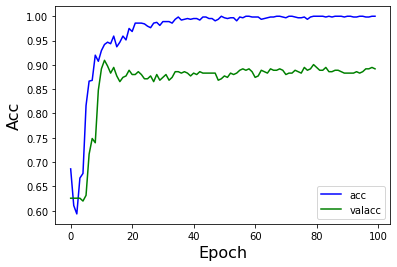

In [ ]:
x = [i for i in range(100)]
plt.figure()
plt.xlabel('Epoch', fontdict={'size': 16})
plt.ylabel('Acc',fontdict={'size': 16})
# plt.plot(x, loss, color='blue', label='loss')
# plt.plot(x, valloss,color='green', label='val_loss')
plt.plot(x, acc, color='blue', label='acc')
plt.plot(x, valacc,color='green', label='valacc')
plt.legend(loc='best')
plt.savefig('/content/gdrive/MyDrive/UV3/resultImage/Fusion_ACC.png',dpi=600)
plt.show()

#模型测试

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, cohen_kappa_score
import matplotlib.pyplot as pl
def get_OA(cm):
    
    total = cm.sum()
    
    diag_arr = np.diagonal(cm, offset=0)
    
    correct = diag_arr.sum()
    
    OA = (correct/total) * 100
    
    return OA

def get_cm_oa_kappa(Y_test, Y_pred,threshold=0.8):
    
    Y_pred = np.argmax(Y_pred, axis=1)
    
    Y_test = Y_test.tolist()
    Y_pred = Y_pred.tolist()
   
    cm = confusion_matrix(Y_test,Y_pred)
    
    oa = get_OA(cm)
    
    kappa = cohen_kappa_score(Y_test,Y_pred)
    
    # print(cm)
    
    return cm, oa, kappa
def plot_matrix(y_test, y_pred, labels_name, title=None, thresh=0.8, axis_labels=None):
  Y_pred = np.argmax(y_pred, axis=1)
  
  y_true = y_test.tolist()
  Y_pred = Y_pred.tolist()
# 利用sklearn中的函数生成混淆矩阵并归一化
  cm = confusion_matrix(y_true, Y_pred)  # 生成混淆矩阵 
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # 归一化

# 画图，如果希望改变颜色风格，可以改变此部分的cmap=pl.get_cmap('Blues')处
  pl.imshow(cm, interpolation='nearest', cmap=pl.get_cmap('Blues'))
  pl.colorbar()  # 绘制图例
  pl.title(title, fontsize=15,fontfamily='SimHei')
# 图像标题
  if title is not None:
      pl.title(title)
# 绘制坐标
  num_local = np.array(range(len(labels_name)))
  if axis_labels is None:
      axis_labels = labels_name
  pl.xticks(num_local, axis_labels, rotation=45, fontsize=10)  # 将标签印在x轴坐标上， 并倾斜45度
  pl.yticks(num_local, axis_labels, fontsize=10)  # 将标签印在y轴坐标上
  pl.ylabel('True label',fontsize=12,verticalalignment='center')
  pl.xlabel('Predicted label',fontsize=12,verticalalignment='center')
  

# 将百分比打印在相应的格子内，大于thresh的用白字，小于的用黑字
  for i in range(np.shape(cm)[0]):
      for j in range(np.shape(cm)[1]):
          if int(cm[i][j] * 100 + 0.5) > 0:
              pl.text(j, i, format(int(cm[i][j] * 100), 'd') + '%',
                      ha="center", va="center",
                      color="white" if cm[i][j] > thresh else "black")  # 如果要更改颜色风格，需要同时更改此行
# 显示
  # pl.figure(dpi=1000) 
  pl.savefig('/content/gdrive/MyDrive/UV3/resultImage/Fusioncm.png',dpi=1000,bbox_inches = 'tight')
 
  pl.show()

In [ ]:
test_y = to_categorical(test_Y)
test_x = [
    test_X[:,0,:,:,:],
    test_X[:,1,:,:,:],
    test_X[:,2,:,:,:],
    test_X[:,3,:,:,:],
    test_X[:,4,:,:,:]        
  ]
# test_y = to_categorical(test_Y)
# test_x = test_X[:,0,:,:,:]
 

In [ ]:
labels = ['UV', 'non-UV']

In [ ]:
# inputUV = L.Input(shape=inputShape)
# testmodel = OnlyDNCNN(inputUV)
# testmodel.load_weights('/content/gdrive/MyDrive/UV3/result/DNCNN_test.h5')
CNN_model = efn.EfficientNetB0()
testmodel = fusionModel(CNN_model)
testmodel.load_weights('/content/gdrive/MyDrive/UV3/result/fusionModel_test.h5')


In [ ]:
Y_pred = testmodel.predict(test_x, verbose=1)

11/11 [==============================] - 21s 2s/step


In [ ]:
cm, oa, kappa = get_cm_oa_kappa(test_Y, Y_pred)
print('acc: {:.2f}%  Kappa: {:.4f}'.format(oa,kappa))
print('acc: {:2f}%'.format(oa))
print(cm)

acc: 90.06%  Kappa: 0.7864
acc: 90.058480%
[[109  19]
 [ 15 199]]


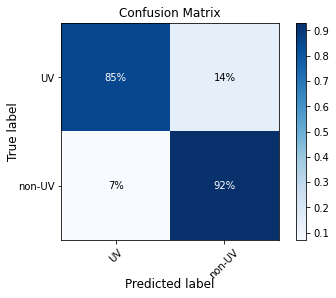

In [ ]:
plot_matrix(test_Y ,Y_pred, [0,1], title='Confusion Matrix',axis_labels=labels)